# Lab Assignment Three: Extending Logistic Regression

CS 7324

2021-03-07

Anthony Wang

## Preparation and Overview

[This image dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset) is a collection of pictures taken of nine types of seafood widely consumed in the Aegean Region of Turkey. The seafood include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, and shrimp. The dataset contains one thousand 590 px by 445 px images of of each, but this analysis will use only two hundred images of each type due to memory, network, and computational limitations.

[These pictures were taken specifically for feature extraction and species classification purposes](https://ieeexplore.ieee.org/abstract/document/9259867), and that is what this analysis will do. Such data could be used to develop machinery that could automatically sort fish using visual sensors. This would be useful to markets and fisheries which would need to dedicated less workers to manually sorting fish. The model integrated into the deployed machinery would need to classify in real-time. In this use case, useful classification accuracy would depend on how quickly workers manually sort seafood, what their wages are, and the price of mechanical/computing equipment. These factors would differ in every environment, so this analysis operates under the assumption that time spent correcting a misclassification would take less than the time spent manually sorting two pieces of seafood. In this case, a classification accuracy greater than 50% would be useful.

Preparation will include scaling images to 295 px by 222 px, half of the original length and width. The images will then be vectorized, keeping the RGB color data. Randomized PCA will then be performed to reduce the data from 196470 features to 300, preserving over 92% of explained variance while massively reducing computational complexity. Previous exploration showed that for this dataset, PCA and Randomized PCA have produce indiscernible results, but Randomized PCA completes in half the time.

In [1]:
import numpy
from PIL import Image   # Image resizing
import requests         # Downloading dataset

# Indices will be extracted from this list for one-hot encoding
fish_types = [
    "Black Sea Sprat",
    "Gilt-Head Bream",
    "Horse Mackerel",
    "Red Mullet",
    "Red Sea Bream",
    "Sea Bass",
    "Shrimp",
    "Striped Red Mullet",
    "Trout"
]

dataset_root = "https://raw.githubusercontent.com/Djaenk/Artificial-Intelligence-Python/main/Fish_Dataset/"

data = numpy.empty((1800,196470))
target = numpy.empty((1800,), dtype='i1')
height = 222
width = 295
channels = 3

for i in range(len(fish_types)):
    print("Loading", fish_types[i], "images...")
    for j in range(200):
        # Load image
        url = dataset_root + fish_types[i] + "/" + str(j + 1).zfill(5) + ".png"
        image = Image.open(requests.get(url, stream = True).raw)
        image = image.resize((width, height))

        # Convert image to numpy array
        image_array = numpy.array(image) / 255

        # Vectorize image
        image_vector = image_array.ravel()

        # Append vectorized image to data matrix
        index = i * 200 + j
        data[index] = image_vector
        target[index] = i

        # Display first image of each type
        if j % 200 == 0:
            display(image)
            print()

Loading Black Sea Sprat images...
Loading Gilt-Head Bream images...
Loading Horse Mackerel images...
Loading Red Mullet images...
Loading Red Sea Bream images...
Loading Sea Bass images...
Loading Shrimp images...
Loading Striped Red Mullet images...
Loading Trout images...


In [8]:
from sklearn.decomposition import PCA

n_components = 300
rpca = PCA(n_components=n_components, svd_solver="randomized")
data_reduced = rpca.fit_transform(data)

print("Cumulative explained variance ratio:", numpy.cumsum(rpca.explained_variance_ratio_)[-1])

Cumulative explained variance ratio: 0.9247106879531521


With a total of 1800 samples, there are 200 samples in each class. This is few enough to desire a testing sample greater than 40 which would be set aside using an 80/20 split. A larger test size, such as with a 70/30 split, may give more satisfactory variance in the performance measure.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_reduced, target, test_size=0.2)
print(X_test.shape)

(360, 300)


## Modeling

In [147]:
import numpy
from scipy.special import expit # expit(x) = 1/(1+exp(-x))
from numpy.linalg import pinv   # pseudo-inversion of hessian
from random import randrange    # for selecting a random instance in stochastic gradient descent

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, solver='newton', regularization="L2", C=0.0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.reg = regularization.lower()
        self.C = C
        # self.w_ to store weights
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    @staticmethod
    def _add_bias(X):
        return numpy.hstack((numpy.ones((X.shape[0],1)),X)) # add bias term
        
    def _get_gradient(self, X, y):
        if(self.solver == 'steepest descent'):
            difference = y - expit(X @ self.w_).ravel()
            gradient = numpy.mean(X * difference[:,numpy.newaxis], axis=0)
        elif(self.solver == 'stochastic descent'):
            index = randrange(len(y))
            difference = y[index] - expit(X[index] @ self.w_)
            gradient = X[index] * difference[:,numpy.newaxis]
        elif(self.solver == 'MSE'):
            sigmoid = expit(X @ self.w_).ravel()
            difference = sigmoid * (1 - sigmoid) * (y - sigmoid)
            gradient = 2 * numpy.mean(X * difference[:,numpy.newaxis], axis=0)
        else:
            sigmoid = expit(X @ self.w_).ravel()
            hessian = numpy.array(X.T @ numpy.diag(sigmoid * (1 - sigmoid)) @ X - 2 * self.C, dtype='float')
            difference = y - sigmoid
            gradient = numpy.sum(X * difference[:,numpy.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)

        if('l1' in self.reg):
            gradient[1:] += -2 * self.w_[1:] * self.C
        if('l2' in self.reg):
            gradient[1:] += numpy.sign(self.w_[1:]) * self.C

        if(self.solver == 'newton'):
            return pinv(hessian) @ gradient
        else:
            return gradient

    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
        self.w_ = numpy.zeros((num_features, 1))
        for i in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += self.eta * gradient
    
    def predict_proba(self, X):
        return expit(self._add_bias(X) @ self.w_)

    def predict(self,X):
        return self.predict_proba(X) > 0.5

In [74]:
class LogisticRegression:
    def __init__(self, eta, iterations=20, solver='newton', regularization="L2", C=0.0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.reg = regularization.lower()
        self.C = C
        # self.w_ to store weights

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = numpy.unique(y)
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i, yval in enumerate(self.unique_):
            y_binary = (y == yval)
            blr = BinaryLogisticRegression(self.eta, self.iters, self.solver, self.reg, self.C)
            blr.fit(X,y_binary)
            self.classifiers_.append(blr)
        self.w_ = numpy.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probabilities = []
        for blr in self.classifiers_:
            probabilities.append(blr.predict_proba(X))
        return numpy.hstack(probabilities)

    def predict(self, X):
        return self.unique_[numpy.argmax(self.predict_proba(X), axis=1)]

### Parameter Optimization of Logistic Regression Solvers

Adjustment of eta, C, and regularization for each solver is done by exhaustively testing parameter values to fit. For each solver, the ranges remain the same, but the resolution of each range is adjusted based on the magnitude of iterations each method is run for, which in turn is determined by maintaining relatively equal runtimes between each solver. There should not be any data snooping involved, as the values yielding the greatest accuracy are selected for each solver.

The results below indicate that a logistic regression using Newton's method yields the greatest accuracy. Thus it will be compared to the scikit-learn logistic regression implementation.

In [126]:
from sklearn.metrics import accuracy_score

regularization = ['none', 'L1', 'L2', 'L1L2']

# Helper function for testing regression and getting accuracy
def test_logistic_regression(**kwargs):
    lr = LogisticRegression(**kwargs)
    lr.fit(X_train, y_train)
    yhat = lr.predict(X_test)
    return accuracy_score(y_test, yhat)

#### Steepest Gradient Descent

In [141]:
eta = [i / 1000 for i in range(100)]
eta_accuracies = []
best_eta = 0
max_accuracy = 0
for value in eta:
    accuracy = test_logistic_regression(eta=value, solver='steepest descent')
    eta_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_eta = value
        print(f'{value}: {accuracy}')

0.0: 0.09722222222222222
0.001: 0.5805555555555556
0.002: 0.6527777777777778
0.003: 0.675
0.004: 0.7
0.005: 0.7111111111111111
0.006: 0.725
0.007: 0.7305555555555555
0.008: 0.75
0.009: 0.7611111111111111
0.01: 0.7722222222222223


In [142]:
C = [i / 100 for i in range(100)]
C_accuracies = []
best_C = 0
max_accuracy = 0
for value in C:
    accuracy = test_logistic_regression(eta=best_eta, C=value, solver='steepest descent')
    C_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = value
        print(f'{value}: {accuracy}')

0.0: 0.7722222222222223
0.01: 0.7916666666666666
0.02: 0.7944444444444444


In [143]:
reg_accuracies = []
best_reg = ''
max_accuracy = 0
for reg in regularization:
    accuracy = test_logistic_regression(eta=best_eta, C=best_C, regularization=reg, solver='steepest descent')
    reg_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_reg = reg
        print(f'{reg}: {accuracy}')

none: 0.7722222222222223
L2: 0.7944444444444444


[Text(0.5, 0, 'Regularization')]

<Figure size 432x288 with 0 Axes>

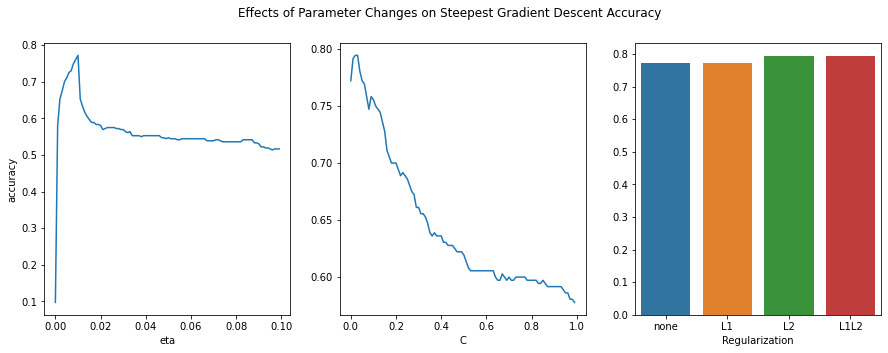

In [92]:
from matplotlib import pyplot
import seaborn

pyplot.figure()
pyplot.subplots(figsize = (15, 5))
pyplot.suptitle("Effects of Parameter Changes on Steepest Gradient Descent Accuracy")

pyplot.subplot(1,3,1)
seaborn.lineplot(eta, eta_accuracies).set(xlabel='eta', ylabel='accuracy')
pyplot.subplot(1,3,2)
seaborn.lineplot(C, C_accuracies).set(xlabel='C')
pyplot.subplot(1,3,3)
seaborn.barplot(regularization, reg_accuracies).set(xlabel='Regularization')

#### Stochastic Gradient Descent

In [102]:
# Faster execution time of stochastic descent allows for more
# iterations, and thus more minute values of eta and C
eta_stochastic = [i / 10000 for i in range(1000)]
eta_s_accuracies = []
best_eta = 0
max_accuracy = 0
for value in eta_stochastic:
    accuracy = test_logistic_regression(eta=value, iterations=200, solver='stochastic descent')
    eta_s_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_eta = value
        print(f'{value}: {accuracy}')

0.0: 0.09722222222222222
0.0001: 0.4083333333333333
0.0006: 0.41388888888888886
0.0022: 0.4166666666666667


In [103]:
C_stochastic = [i / 1000 for i in range(1000)]
C_s_accuracies = []
best_C = 0
max_accuracy = 0
for value in C_stochastic:
    accuracy = test_logistic_regression(eta=best_eta, iterations=200, C=value, solver='stochastic descent')
    C_s_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = value
        print(f'{value}: {accuracy}')

0.0: 0.3333333333333333
0.004: 0.3527777777777778
0.01: 0.3611111111111111
0.013: 0.3638888888888889
0.019: 0.36666666666666664
0.028: 0.38055555555555554
0.031: 0.3888888888888889
0.094: 0.39166666666666666
0.1: 0.40555555555555556
0.105: 0.4111111111111111
0.167: 0.41944444444444445
0.202: 0.43333333333333335
0.236: 0.4444444444444444


In [121]:
reg_accuracies = []
best_reg = ''
max_accuracy = 0
for reg in regularization:
    accuracy = test_logistic_regression(eta=best_eta, C=best_C, regularization=reg, solver='stochastic descent')
    reg_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_reg = reg
        print(f'{reg}: {accuracy}')

none: 0.16666666666666666
L2: 0.20833333333333334
L1L2: 0.26666666666666666


[Text(0.5, 0, 'Regularization')]

<Figure size 432x288 with 0 Axes>

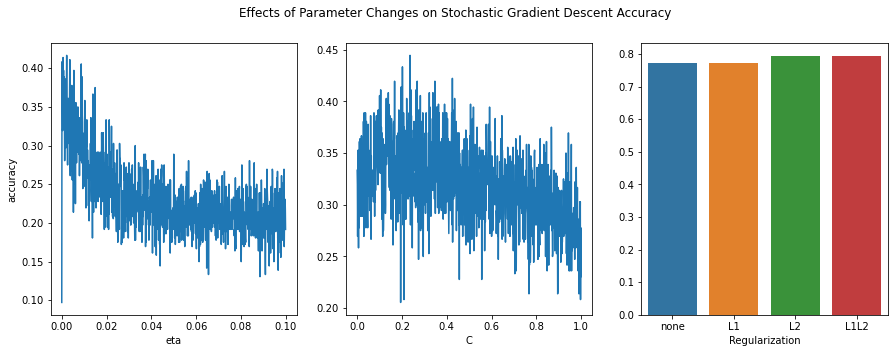

In [146]:
from matplotlib import pyplot
import seaborn

pyplot.figure()
pyplot.subplots(figsize = (15, 5))
pyplot.suptitle("Effects of Parameter Changes on Stochastic Gradient Descent Accuracy")

pyplot.subplot(1,3,1)
seaborn.lineplot(eta_stochastic, eta_s_accuracies).set(xlabel='eta', ylabel='accuracy')
pyplot.subplot(1,3,2)
seaborn.lineplot(C_stochastic, C_s_accuracies).set(xlabel='C')
pyplot.subplot(1,3,3)
seaborn.barplot(regularization, reg_accuracies).set(xlabel='Regularization')

#### Newton's Method

In [132]:
# Fewer iterations for Newton's method necessitate coarser
# values of C and eta
eta_newton = [i / 100 for i in range(10)]
eta_accuracies = []
best_eta = 0
max_accuracy = 0
for value in eta:
    accuracy = test_logistic_regression(eta=value, iterations=2, solver='newton')
    eta_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_eta = value
        print(f'{value}: {accuracy}')

0.0: 0.09722222222222222
0.001: 0.9305555555555556


In [133]:
C = [i / 10 for i in range(10)]
C_accuracies = []
best_C = 0
max_accuracy = 0
for value in C:
    accuracy = test_logistic_regression(eta=best_eta, iterations=2, C=value, solver='newton')
    C_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = value
        print(f'{value}: {accuracy}')

0.0: 0.9305555555555556


In [134]:
reg_accuracies = []
best_reg = ''
max_accuracy = 0
for reg in regularization:
    accuracy = test_logistic_regression(eta=best_eta, C=best_C, iterations=2, regularization=reg, solver='newton')
    reg_accuracies.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_reg = reg
        print(f'{reg}: {accuracy}')

none: 0.9305555555555556


[Text(0.5, 0, 'Regularization')]

<Figure size 432x288 with 0 Axes>

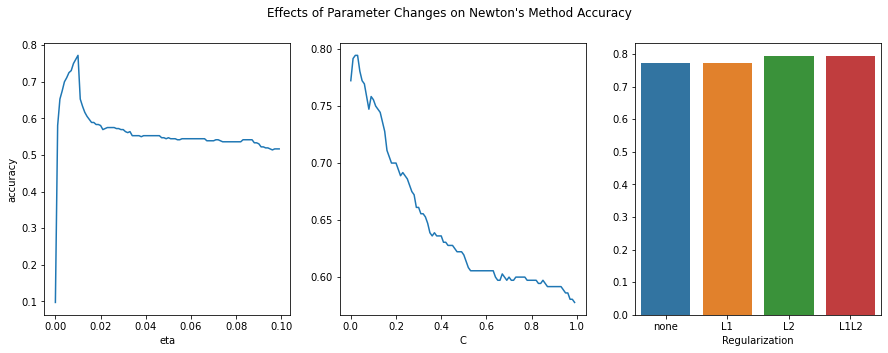

In [145]:
from matplotlib import pyplot
import seaborn

pyplot.figure()
pyplot.subplots(figsize = (15, 5))
pyplot.suptitle("Effects of Parameter Changes on Newton's Method Accuracy")

pyplot.subplot(1,3,1)
seaborn.lineplot(eta, eta_accuracies).set(xlabel='eta', ylabel='accuracy')
pyplot.subplot(1,3,2)
seaborn.lineplot(C, C_accuracies).set(xlabel='C')
pyplot.subplot(1,3,3)
seaborn.barplot(regularization, reg_accuracies).set(xlabel='Regularization')

#### Additional Implementation of Mean Squared Error and Comparison to Maximum Likelihood Estimate

In [140]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

# Uses parameters optimized for Newton's method
lr = LogisticRegression(eta=best_eta, C=best_C, iterations=2, regularization=reg, solver='newton')
sk_lr = SKLogisticRegression()

print('Time to train custom newton vs scikit-learn')
%time lr.fit(X_train, y_train)
%time sk_lr.fit(X_train, y_train)

lr_yhat = lr.predict(X_test)
sk_lr_yhat = sk_lr.predict(X_test)

print('\nAccuracy of custom newton vs scikit-learn')
print(accuracy_score(y_test, lr_yhat))
print(accuracy_score(y_test, sk_lr_yhat))

Time to train custom newton vs scikit-learn
Wall time: 1.05 s
Wall time: 199 ms

Accuracy of custom newton vs scikit-learn
0.9305555555555556
0.9638888888888889


## Deployment

Even without any experimental results, intuition would suggest that a partially precompiled, C++ accelerated library frequently updated by over a thousand contributors should outperform a few hours' worth of effort from a novice computer scientist. The empirical outcomes above show the superiority of the scikit-learn logistic regression implementation. The open source regression classifier likely uses methods and theory not covered in this analysis to achieve its greater speed and accuracy. It is faster to train by a factor of five and three percentage points more accurate. There is no question that the scikit-learn model is a better choice for deployment in real-world use. If there exists a third-party model which achieves even greater accuracy, it should certainly be considered as well.

## Custom Implementation of BFGS and Comparison to SciPy Implementation

The `LogisticRegression` class presented earlier also implements a solver which uses a mean squared error objective function with steepest descent.

In [150]:
# Uses parameters optimized for steepest gradient descent
lr_mle = LogisticRegression(eta=best_eta, C=best_C, iterations=2, regularization=reg, solver='steepest descent')
lr_mse = LogisticRegression(eta=best_eta, C=best_C, iterations=2, regularization=reg, solver='MSE')

print('Time to train MLE vs MSE')
%time lr_mle.fit(X_train, y_train)
%time lr_mse.fit(X_train, y_train)

lr_mle_yhat = lr_mle.predict(X_test)
lr_mse_yhat = lr_mse.predict(X_test)

print('\nAccuracy of MLE vs MSE')
print(accuracy_score(y_test, lr_mle_yhat))
print(accuracy_score(y_test, lr_mse_yhat))

Time to train MLE vs MSE
Wall time: 42.9 ms
Wall time: 42 ms

Accuracy of MLE vs MSE
0.5833333333333334
0.525


The training times and accuracies are very similar, given the results. The log-likelihood objective function is still preferred because it yields a greater accuracy with a negligible impact on execution time.